## Exercise 8 | Anomaly Detection and Collaborative Filtering
### ================== Part 1: Load Example Dataset  ===================

Visualizing example dataset for outlier detection.



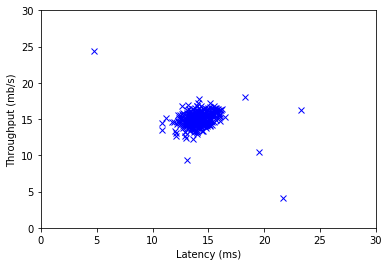

In [1]:
from ex8 import *
%matplotlib inline
print('Visualizing example dataset for outlier detection.\n')

#  The following command loads the dataset. You should now have the
#  variables X, Xval, yval in your environment
from scipy import io as sio
data = sio.loadmat('ex8data1.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].reshape(-1)

#  Visualize the example dataset
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.axis([0, 30, 0, 30])
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### ================== Part 2: Estimate the dataset statistics ===================
$$\mu_j = \frac{1}{m}\sum_{i=1}^{m}{x_j^{(i)}}$$
$$\sigma_j^2 = \frac{1}{m}\sum_{i=1}^{m}{\left(x_j^{(i)} - \mu_j\right)^2}$$
$$p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

Visualizing Gaussian fit.



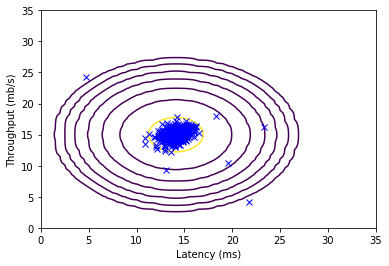

In [2]:
print('Visualizing Gaussian fit.\n')

#  Estimate my and sigma2
mu, sigma2 = estimateGaussian(X)

#  Returns the density of the multivariate normal at each data point (row) 
#  of X
p = multivariateGaussian(X, mu, sigma2)

#  Visualize the fit
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### ================== Part 3: Find Outliers ===================

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000
   (you should see a value epsilon of about 8.99e-05)
   (you should see a Best F1 value of  0.875000)



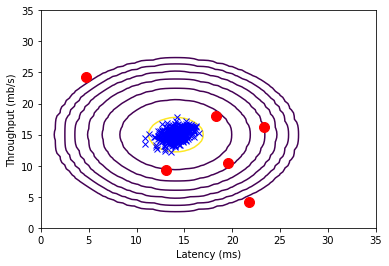

In [3]:
pval = multivariateGaussian(Xval, mu, sigma2)

epsilon, F1 = selectThreshold(yval, pval)
print(f'Best epsilon found using cross-validation: {epsilon:e}')
print(f'Best F1 on Cross Validation Set:  {F1:f}')
print('   (you should see a value epsilon of about 8.99e-05)')
print('   (you should see a Best F1 value of  0.875000)\n')

#  Find the outliers in the training set and plot the
outliers = p < epsilon

#  Draw a red circle around those outliers
plt.figure()
visualizeFit(X,  mu, sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', linewidth=2, markersize=10)
plt.show()

### ================== Part 4: Multidimensional Outliers ===================

In [4]:
#  Loads the second dataset. You should now have the
#  variables X, Xval, yval in your environment
data = sio.loadmat('ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval'].reshape(-1)

#  Apply the same steps to the larger dataset
mu, sigma2 = estimateGaussian(X)

#  Training set 
p = multivariateGaussian(X, mu, sigma2)

#  Cross-validation set
pval = multivariateGaussian(Xval, mu, sigma2)

#  Find the best threshold
epsilon, F1 = selectThreshold(yval, pval)

print(f'Best epsilon found using cross-validation: {epsilon:e}')
print(f'Best F1 on Cross Validation Set:  {F1:f}')
print('   (you should see a value epsilon of about 1.38e-18)')
print('   (you should see a Best F1 value of 0.615385)')
print(f'# Outliers found: {(p < epsilon).sum()}')

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
   (you should see a value epsilon of about 1.38e-18)
   (you should see a Best F1 value of 0.615385)
# Outliers found: 117


###### 以上部分代码在[ex8.py](https://github.com/StevenPZChan/ml_dl_coursera_Andrew_Ng/blob/master/machine-learning-python/machine-learning-ex8/ex8.py)中

### =============== Part 1: Loading movie ratings dataset ================

Loading movie ratings dataset.

Average rating for movie 1 (Toy Story): 3.878319 / 5



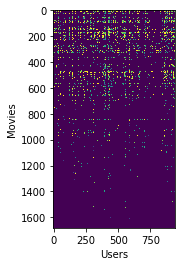

In [5]:
from ex8_cofi import *
print('Loading movie ratings dataset.\n')

#  Load data
from scipy import io as sio
data = sio.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  From the matrix, we can compute statistics like average rating.
print(f'Average rating for movie 1 (Toy Story): {Y[0, R[0, :].astype(bool)].mean():f} / 5\n')

#  We can "visualize" the ratings matrix by plotting it with imagesc
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.show()

### ============ Part 2: Collaborative Filtering Cost Function ===========
$$J(x^{(1)},\ldots,x^{(n_m)},\theta^{(1)},\ldots,\theta^{(n_u)}) = \frac{1}{2}\sum_{(i,j):r(i,j)=1}{\left((\theta^{(j)})^Tx^{(i)} - y^{(i,j)}\right)^2 + \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}{\left(x_k^{(i)}\right)^2} + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}{\left(\theta_k^{(i)}\right)^2}}$$

In [6]:
#  Load pre-trained weights (X, Theta, num_users, num_movies, num_features)
data = sio.loadmat('ex8_movieParams.mat')
X = data['X']
Theta = data['Theta']
num_users = np.asscalar(data['num_users'])
num_movies = np.asscalar(data['num_movies'])
num_features = np.asscalar(data['num_features'])

#  Reduce the data set size so that this runs faster
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]), Y, R, num_users, num_movies, num_features, 0)
           
print(f'Cost at loaded parameters: {J:f} '
         '\n(this value should be about 22.22)')

Cost at loaded parameters: 22.224604 
(this value should be about 22.22)


### ============== Part 3: Collaborative Filtering Gradient ==============
$$\frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1}{\left((\theta^{(j)})^Tx^{(i)} - y^{(i,j)}\right)\theta_k^{(j)} + \lambda x_k^{(i)}}$$
$$\frac{\partial J}{\partial\theta_k^{(j)}} = \sum_{i:r(i,j)=1}{\left((\theta^{(j)})^Tx^{(i)} - y^{(i,j)}\right)x_k^{(i)} + \lambda\theta_k^{(j)}}$$

In [7]:
print('Checking Gradients (without regularization) ... ')

#  Check gradients by running checkNNGradients
checkCostFunction()

Checking Gradients (without regularization) ... 
[[ -4.007977  -4.007977]
 [  2.710351   2.710351]
 [  2.65428    2.65428 ]
 [ -0.049014  -0.049014]
 [  0.11209    0.11209 ]
 [  0.07776    0.07776 ]
 [  0.564534   0.564534]
 [-11.096384 -11.096384]
 [  4.779287   4.779287]
 [  0.992009   0.992009]
 [  0.092185   0.092185]
 [ -0.35919   -0.35919 ]
 [ -4.005086  -4.005086]
 [  6.281983   6.281983]
 [ -3.042467  -3.042467]
 [  1.147838   1.147838]
 [ -1.993641  -1.993641]
 [ -0.158091  -0.158091]
 [  2.454774   2.454774]
 [ -3.483138  -3.483138]
 [ -3.698394  -3.698394]
 [  3.871281   3.871281]
 [ -5.986774  -5.986774]
 [  5.496491   5.496491]
 [  0.033889   0.033889]
 [ -0.246756  -0.246756]
 [  0.509833   0.509833]]
['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)']
If your cost function implementation is correct, then 
the relative difference will be small (less than 1e-9). 

Relative Difference: 1.9003e-12


### ========= Part 4: Collaborative Filtering Cost Regularization ========

In [8]:
#  Evaluate cost function
J, _ = cofiCostFunc(np.concatenate([X.reshape(-1), Theta.reshape(-1)]), Y, R, num_users, num_movies, num_features, 1.5)
           
print(f'Cost at loaded parameters (lambda = 1.5): {J:f} '
         '\n(this value should be about 31.34)')

Cost at loaded parameters (lambda = 1.5): 31.344056 
(this value should be about 31.34)


### ======= Part 5: Collaborative Filtering Gradient Regularization ======

In [9]:
print('Checking Gradients (with regularization) ... ')

#  Check gradients by running checkNNGradients
checkCostFunction(1.5)

Checking Gradients (with regularization) ... 
[[-4.619530e-01 -4.619530e-01]
 [-1.050700e+00 -1.050700e+00]
 [ 1.612006e+01  1.612006e+01]
 [ 3.154325e-01  3.154325e-01]
 [ 2.677497e+00  2.677497e+00]
 [ 5.077390e+00  5.077390e+00]
 [-8.580218e-01 -8.580218e-01]
 [ 2.552349e+00  2.552349e+00]
 [ 3.537703e+00  3.537703e+00]
 [ 2.066214e+00  2.066214e+00]
 [-3.677363e+00 -3.677363e+00]
 [ 1.642278e+01  1.642278e+01]
 [-4.046519e-01 -4.046519e-01]
 [-3.083852e+00 -3.083852e+00]
 [-4.005439e+00 -4.005439e+00]
 [-3.797228e+00 -3.797228e+00]
 [ 2.835593e+00  2.835593e+00]
 [-1.318965e+01 -1.318965e+01]
 [-2.383072e+00 -2.383072e+00]
 [ 9.827656e-03  9.827656e-03]
 [-3.979154e+00 -3.979154e+00]
 [ 8.684664e-01  8.684664e-01]
 [ 2.169383e+00  2.169383e+00]
 [ 2.258721e+00  2.258721e+00]
 [-8.594728e-01 -8.594728e-01]
 [ 3.472921e+00  3.472921e+00]
 [ 1.809470e+00  1.809470e+00]]
['The above two columns you get should be very similar.\n(Left-Your Numerical Gradient, Right-Analytical Gradient)']

### ============== Part 6: Entering ratings for a new user ===============

In [10]:
movieList = loadMovieList()

#  Initialize my ratings
my_ratings = np.zeros(1682)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Rated {my_ratings[i]:g} for {movieList[i]}')

New user ratings:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)
Rated 5 for Die Hard 2 (1990)
Rated 5 for Sphere (1998)


### ================== Part 7: Learning Movie Ratings ====================

In [11]:
print('Training collaborative filtering...')

#  Load data
data = sio.loadmat('ex8_movies.mat')
Y = data['Y']
R = data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users
#
#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.column_stack([my_ratings, Y])
R = np.column_stack([(my_ratings != 0).astype(int), R])

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

# Set Initial Parameters (Theta, X)
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

initial_parameters = np.concatenate([X.reshape(-1), Theta.reshape(-1)])

# Set options for fmincg
options = {'disp': True, 'maxiter': None}

# Set Regularization
from scipy import optimize as opt
lambda_ = 10
res = opt.minimize(lambda t: cofiCostFunc(t, Ynorm, R, num_users, num_movies, num_features, lambda_)[0], initial_parameters,
                   method='CG', jac=lambda t: cofiCostFunc(t, Ynorm, R, num_users, num_movies, num_features, lambda_)[1], options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies * num_features].reshape((num_movies, num_features))
Theta = theta[num_movies * num_features:].reshape((num_users, num_features))

print('Recommender system learning completed.')

Training collaborative filtering...
         Current function value: 38951.847560
         Iterations: 371
         Function evaluations: 555
         Gradient evaluations: 554
Recommender system learning completed.


### ================== Part 8: Recommendation for you ====================

In [12]:
p = np.matmul(X, Theta.transpose())
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

ix = my_predictions.argsort()[::-1]
print('Top recommendations for you:')
for i in range(10):
    j = ix[i]
    print(f'Predicting rating {my_predictions[j]:.1f} for movie {movieList[j]}')

print('\n\nOriginal ratings provided:')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(f'Rated {my_ratings[i]:g} for {movieList[i]}')

Top recommendations for you:
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie Aiqing wansui (1994)


Original ratings provided:
Rated 4 for Toy Story (1995)
Rated 3 for Twelve Monkeys (1995)
Rated 5 for Usual Suspects, The (1995)
Rated 4 for Outbreak (1995)
Rated 5 for Shawshank Redemption, The (1994)
Rated 3 for While You Were Sleeping (1995)
Rated 5 for Forrest Gump (1994)
Rated 2 for Silence of the Lambs, The (1991)
Rated 4 for Alien (1979)


跟说明文档里面的结果不太一样，估计是因为数据太少吧。
###### 以上部分代码在[ex8_cofi.py](https://github.com/StevenPZChan/ml_dl_coursera_Andrew_Ng/blob/master/machine-learning-python/machine-learning-ex8/ex8_cofi.py)中

### 总结：矩阵范数需要用到`numpy.linalg.norm`，求逆是`numpy.linalg.pinv`，电影列表的文本文档居然要用`ISO-8859-1`编码才能正确读取。
---
### 机器学习的8次作业完结撒花